## From Run Expectancy to Wins Above Replacement (WAR)

The Run Expectancy Matrix is a context-dependent measure of productivity. By introducing the context of a hit or a walk to the state of the game, it provides a more accurate measure of the contribution of a position player. 

In the previous notebook we derived the Runs Value of an event, measured by the runs scored on the play, plus the Runs Expectancy at the end of the play minus the Run Expectancy at the beginning of the play. We also measured the season-long contribution of the position player as the sum of Runs Values across all plate appearances.

The Run Expectancy Matrix has been used in recent years to develop new ways of valuing player contributions. Because the underlying data has not been easily available until recently, and because deriving the matrix from the data was not easy in the past, the Run Expectancy Matrix has been adapted in simple ways.

In the previous notebooks we looked at On Base Percentage (OBP) and Slugging (SLG). In recent years an increasingly popular statistic for measuring performance has been On-base Plus Slugging (OPS). OPS = OBP + SLG (hence the name "On-base Plus Slugging"). This measure is useful since it recognizes both the value of getting on base and extra value of doubles, triples, and home runs. 

However, as a measure of contribution, it implicitly imposes equal weights on each element of the formula. Is a double worth exactly twice a single in terms of runs scored? We shouldn't assume that - we should let the data tell us. This is exactly the idea behind the use of "linear weights" to calculate weighted on-base average (wOBA). The linear weights are taken from the Run Expectancy Matrix.

There are different versions of wOBA out there depending on different adjustments preferred by different analysts. Remember that the Run Expectancy Matrix changes from year to year, and hence analysts like to evaluate a player relative to the RE Matrix of the season from which their stats are derived. 

For example, Fangraphs, a popular baseball statistics site, defined the following formula for wOBA in 2018:

wOBA = (0.69*NIBB + 0.72*HBP + 0.88*1B + 1.247*2B + 1.578*3B + 2.031*HR)/(AB + BB - IBB +SF + HBP)

where NIBB and IBB are non-intentional and intentional walks.

The weights in wOBA are taken from the Run Expectancy Matrix. Sites such as Fangraphs and Baseball Reference generate these statistics, and then use the coefficients to generate measures such as wOBA, which they consider an improvement on On-base Plus Slugging (OPS).

To take this further, analysts have created statistics to account for the total contribution of a player, one of the most popular being Wins Above Replacement (WAR). Most measures of WAR are based around calculations of wOBA for position players. We can summarize three aims in the creation of these statistics:

>(i) To account for the four dimensions of on-field performance - batting, base-running, pitching, and fielding. The first two constitute offense, the last two defense. While base-running and fielding make a difference, it is batting and pitching which generate most value added in the game. One can think of pitching, in terms of the Run Expectancy Matrix, as the opposite of batting- if a play generates a positive Run Value for the batter, it creates an equal and opposite Run Value for the pitcher. 

>(ii) To adjust for differences in productivity which are unrelated to the skill of the player. The obvious adjustment here is for the size of the ballpark- some are easier for offense than than others, so player stats can be adjusted to take account of these differences. More subtly, a left-handed batter has an advantage over a right-handed batter when facing a right-handed pitcher - the so-called "Platoon Effect" - this advantage is often calculated and then deducted from the batter's Run Value.

>(iii) To express the value of a player relative to a replacement player. If a player is injured, the team typically brings up a player from the minor leagues. Thus the true value of a player is his productivity relative to this likely replacement. Replacement value is usually calculated by averaging the statistics of players with a small number of appearances over the season, since these players are likely to be similar to players called up from the minors.


So far we have measured performance in terms of runs. For ease of interpretation (only), WAR is expressed in terms of wins, where a win is typically valued at around ten wins.

In what follows we're going to focus only on batting (which is essentially offensive WAR) and ignore all of the adjustments. Not adjusting the figures might reduce their reliability, but our use of the RE Matrix has one big advantage over WAR based on wOBA. While Run Expectancy takes into account the context of an event, the linear weights are applied to average performance statistics over the season and are therefore not context dependent. Since we have the Run Expectancy Matrix to work with, our performance stats are context dependent.

# Runs Values 

Here we are going to look at the seasons 2016 and 2017. As ever, we begin by loading the packages we need.

In [1]:
#Load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Writing a Function to Create the Runs Value of Each Event in a Season

In the previous workbook we used the MLBAM data for 2018 to derive the Run Expectancy Matrix and then create the Runs Value of every event. MLBAM has made available files in the same format for each season since 2014. Because the files are structured identically with identical names, we can turn the code into a Python function to produce the RE Matrix and Runs Values for any season, depending on the the file we choose. 

The function always starts with 'def'. Here the name Run_Expectancy is given to it, and it is defined by a path, which is where the data is to be found on which to execute the function. The content of the function (which must be indented) is simply a copy of all the lines of code used in the previous notebook, the only difference now is that the specific name 'MLBAM18' is replaced with a generic name 'RE', while the actual name applied when the function is run is defined when we specify the path. The function is completed by specifying 'return', the name of the output and a semi colon (;).

In [2]:
def Run_Expectancy(path):
    
    RE = pd.read_csv(path)
    RE.drop(['Unnamed: 0'], axis=1, inplace=True)
    RE = RE[['home_team','away_team','half','gameId','batterName','batterId','event', 'start1B', 'start2B', 'start3B',\
             'end1B', 'end2B', 'end3B', 'startOuts','endOuts','runsFuture','runsOnPlay','outsInInning','venueId','batterPos']]
    RE['Start1'] = np.where(pd.isnull(RE['start1B']),0,1)
    RE['Start2'] = np.where(pd.isnull(RE['start2B']),0,1)
    RE['Start3'] = np.where(pd.isnull(RE['start3B']),0,1)
    RE['Start_State'] = (RE['Start1'].astype(str) + RE['Start2'].astype(str) + RE['Start3'].astype(str)+\
                          " " + RE['startOuts'].astype(str))
    RE['End1'] = np.where(pd.isnull(RE['end1B']),0,1)
    RE['End2'] = np.where(pd.isnull(RE['end2B']),0,1)
    RE['End3'] = np.where(pd.isnull(RE['end3B']),0,1)
    RE['End_State'] = (RE['End1'].astype(str) + RE['End2'].astype(str) + RE['End3'].astype(str) + \
                        " " + RE['endOuts'].astype(str))
    RE = RE[((RE.Start_State != RE.End_State) | (RE.runsOnPlay > 0)) & (RE.outsInInning == 3)]
    Start_RunExp = RE.groupby(['Start_State'])['runsFuture'].mean().reset_index().rename(columns={'runsFuture':'Start_RE'})
    RE = pd.merge(RE, Start_RunExp, on=['Start_State'], how='left')
    Base_State_3 = [pd.Series(['000 3', 0], index=Start_RunExp.columns),
                pd.Series(['001 3', 0], index=Start_RunExp.columns),
                pd.Series(['010 3', 0], index=Start_RunExp.columns),
                pd.Series(['011 3', 0], index=Start_RunExp.columns),
                pd.Series(['100 3', 0], index=Start_RunExp.columns),
                pd.Series(['101 3', 0], index=Start_RunExp.columns),
                pd.Series(['110 3', 0], index=Start_RunExp.columns),
                pd.Series(['111 3', 0], index=Start_RunExp.columns)]
    Start_RunExp = Start_RunExp.append(Base_State_3, ignore_index=True)
    End_RunExp  = Start_RunExp.rename(columns={'Start_State':'End_State', 'Start_RE':'End_RE'})
    RE = pd.merge(RE, End_RunExp, on=['End_State'], how='left')
    RE['Run_Value'] = RE['runsOnPlay'] + RE['End_RE'] - RE['Start_RE']
    
    return RE

## Applying the Function Using 2017 Data

We now specify the path (file location) used to run Run_Expectancy for 2017, and give the output the name RE_17.

In [3]:
RE_17 = Run_Expectancy("../Data/MLBAM17.csv")                          
display(RE_17)

,home_team,away_team,half,gameId,batterName,batterId,event,start1B,start2B,start3B,...,Start2,Start3,Start_State,End1,End2,End3,End_State,Start_RE,End_RE,Run_Value
0,tba,nya,top,gid_2017_04_02_nyamlb_tbamlb_1,Gardner,458731,Flyout,NaN,NaN,NaN,...,0,0,000 0,0,0,0,000 1,0.516375,0.272176,-0.244199
1,tba,nya,top,gid_2017_04_02_nyamlb_tbamlb_1,"Sanchez, G",596142,Groundout,NaN,NaN,NaN,...,0,0,000 1,0,0,0,000 2,0.272176,0.108038,-0.164138
2,tba,nya,top,gid_2017_04_02_nyamlb_tbamlb_1,Bird,595885,Walk,NaN,NaN,NaN,...,0,0,000 2,1,0,0,100 2,0.108038,0.225365,0.117327
3,tba,nya,top,gid_2017_04_02_nyamlb_tbamlb_1,Holliday,407812,Groundout,595885.0,NaN,NaN,...,0,0,100 2,0,0,0,000 3,0.225365,0.000000,-0.225365
4,tba,nya,bottom,gid_2017_04_02_nyamlb_tbamlb_1,"Dickerson, C",572816,Single,NaN,NaN,NaN,...,0,0,000 0,1,0,0,100 0,0.516375,0.912921,0.396546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184746,chn,cin,top,gid_2017_10_01_cinmlb_chnmlb_1,Vincej,572227,Runner Out,571740.0,608385.0,NaN,...,1,0,110 2,0,0,0,000 3,0.449782,0.000000,-0.449782
184747,chn,cin,bottom,gid_2017_10_01_cinmlb_chnmlb_1,"Davis, T",543089,Groundout,NaN,NaN,NaN,...,0,0,000 0,0,0,0,000 1,0.516375,0.272176,-0.244199
184748,chn,cin,bottom,gid_2017_10_01_cinmlb_chnmlb_1,Almora Jr.,546991,Home Run,NaN,NaN,NaN,...,0,0,000 1,0,0,0,000 1,0.272176,0.272176,1.000000
184749,chn,cin,bottom,gid_2017_10_01_cinmlb_chnmlb_1,Freeman,502273,Groundout,NaN,NaN,NaN,...,0,0,000 1,0,0,0,000 2,0.272176,0.108038,-0.164138


## We Now Repeat the Same Exercise for 2016

In [4]:
RE_16 = Run_Expectancy("../Data/MLBAM16.csv")                          
display(RE_16)

,home_team,away_team,half,gameId,batterName,batterId,event,start1B,start2B,start3B,...,Start2,Start3,Start_State,End1,End2,End3,End_State,Start_RE,End_RE,Run_Value
0,pit,sln,top,gid_2016_04_03_slnmlb_pitmlb_1,"Carpenter, M",572761,Groundout,NaN,NaN,NaN,...,0,0,000 0,0,0,0,000 1,0.498377,0.268678,-0.229699
1,pit,sln,top,gid_2016_04_03_slnmlb_pitmlb_1,Pham,502054,Groundout,NaN,NaN,NaN,...,0,0,000 1,0,0,0,000 2,0.268678,0.106305,-0.162373
2,pit,sln,top,gid_2016_04_03_slnmlb_pitmlb_1,Holliday,407812,Strikeout,NaN,NaN,NaN,...,0,0,000 2,0,0,0,000 3,0.106305,0.000000,-0.106305
3,pit,sln,bottom,gid_2016_04_03_slnmlb_pitmlb_1,Jaso,444379,Groundout,NaN,NaN,NaN,...,0,0,000 0,0,0,0,000 1,0.498377,0.268678,-0.229699
4,pit,sln,bottom,gid_2016_04_03_slnmlb_pitmlb_1,McCutchen,457705,Hit By Pitch,NaN,NaN,NaN,...,0,0,000 1,1,0,0,100 1,0.268678,0.512225,0.243547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184147,sln,pit,bottom,gid_2016_10_02_pitmlb_slnmlb_1,Moss,461235,Strikeout,594824.0,NaN,NaN,...,0,0,100 2,0,0,0,000 3,0.220539,0.000000,-0.220539
184148,sln,pit,top,gid_2016_10_02_pitmlb_slnmlb_1,"Rogers, J",595386,Groundout,NaN,NaN,NaN,...,0,0,000 0,0,0,0,000 1,0.498377,0.268678,-0.229699
184149,sln,pit,top,gid_2016_10_02_pitmlb_slnmlb_1,Jaso,444379,Walk,NaN,NaN,NaN,...,0,0,000 1,1,0,0,100 1,0.268678,0.512225,0.243547
184150,sln,pit,top,gid_2016_10_02_pitmlb_slnmlb_1,"Polanco, G",570256,Strikeout,444379.0,NaN,NaN,...,0,0,100 1,1,0,0,100 2,0.512225,0.220539,-0.291686


## Self Test

Repeat this exercise for the event data from 2015.

In [5]:
#Your Code Here

## 1. Comparing Event Run Values

To make comparisons between the two seasons we are going (a) use .groupby to generate a statistic for a particular variable (an event, a player, and a team) (b) merge the data for the two seasons (c) derive the correlation and, where suitable, create a scatter diagram.

We start by comparing the Runs Value of events in each season.

In [6]:
#2016
Event_Value16= RE_16.groupby(['event'])['Run_Value'].mean().reset_index().rename(columns = {"Run_Value": 'RV16'})
Event_Value16.sort_values('RV16')

,event,RV16
29,Triple Play,-1.637543
6,Double Play,-0.864981
13,Grounded Into DP,-0.773318
24,Sacrifice Bunt DP,-0.752199
27,Strikeout - DP,-0.622787
10,Fielders Choice Out,-0.610757
23,Sac Fly DP,-0.370443
2,Bunt Lineout,-0.352295
3,Bunt Pop Out,-0.342802
12,Forceout,-0.326657


In [7]:
#2017
Event_Value17= RE_17.groupby(['event'])['Run_Value'].mean().reset_index().rename(columns = {"Run_Value": 'RV17'})
Event_Value17

,event,RV17
0,Batter Interference,-0.430019
1,Bunt Groundout,-0.209411
2,Bunt Lineout,-0.328292
3,Bunt Pop Out,-0.373225
4,Catcher Interference,0.399070
5,Double,0.779338
6,Double Play,-0.897164
7,Fan interference,0.590743
8,Field Error,0.493206
9,Fielders Choice,0.764112


In [8]:
# merge 2016 and 2017
RVseasons= pd.merge(Event_Value16,Event_Value17, on = ['event'])
RVseasons

,event,RV16,RV17
0,Batter Interference,-0.284649,-0.430019
1,Bunt Groundout,-0.218826,-0.209411
2,Bunt Lineout,-0.352295,-0.328292
3,Bunt Pop Out,-0.342802,-0.373225
4,Catcher Interference,0.301623,0.399070
5,Double,0.743467,0.779338
6,Double Play,-0.864981,-0.897164
7,Fan interference,0.533316,0.590743
8,Field Error,0.469989,0.493206
9,Fielders Choice,0.701447,0.764112


In [9]:
# the correlation coefficient
np.corrcoef(RVseasons.RV16,RVseasons.RV17)

array([[1.        , 0.99496361],
       [0.99496361, 1.        ]])

## Conclusion on Event Runs Value Comparison

Although the exact Runs Value of an event can vary from year to year, the pattern of Runs Values across different events appear remarkably consistent,  with a +0.995 correlation coefficient.

## Self Test

Use the Run Expectancy data from 2015 to calculate the correlation coefficient for event Run Values comparing 2015 with 2017.

In [10]:
#Your Code Here

## 2. Comparing Position Player Run Values

We now repeat this comparison, grouping the data by player rather than by event. We use batterId as the matching variable, since each player has a unique number in the data, rather than batterName, since some players may have the same name.

In [9]:
Player_Value16 = RE_16.groupby(['batterId','batterName'])['Run_Value'].sum().reset_index().rename(columns = {"Run_Value": 'RV16'})
Player_Value16

,batterId,batterName,RV16
0,112526,Colon,-15.380841
1,120074,Ortiz,60.938730
2,121347,"Rodriguez, A",-10.691410
3,134181,Beltre,29.745115
4,136860,Beltran,21.279393
...,...,...,...
971,649557,"Diaz, A",16.695314
972,656546,Hoffman,-2.036748
973,656941,Schwarber,-0.779726
974,660162,Moncada,-2.722085


In [10]:
Player_Value17 = RE_17.groupby(['batterId'])['Run_Value'].sum().reset_index().rename(columns = {"Run_Value": 'RV17'})
Player_Value17

,batterId,RV17
0,112526,-6.053060
1,134181,27.205050
2,136860,-16.883042
3,150029,-7.246145
4,276520,-3.530974
...,...,...
952,664056,-1.443276
953,664057,-8.073984
954,664641,-2.145176
955,666561,-3.510460


In [11]:
Players = pd.merge(Player_Value16,Player_Value17, on = ['batterId'])
Players

,batterId,batterName,RV16,RV17
0,112526,Colon,-15.380841,-6.053060
1,134181,Beltre,29.745115,27.205050
2,136860,Beltran,21.279393,-16.883042
3,150029,Werth,6.368448,-7.246145
4,282332,Sabathia,-0.944580,-0.292495
...,...,...,...,...
693,643603,White,-9.482369,2.336055
694,649557,"Diaz, A",16.695314,-12.989348
695,656546,Hoffman,-2.036748,-8.617175
696,656941,Schwarber,-0.779726,1.261717


Using a scatter diagram is a good way to compare consistency between seasons. If performance from season to season were perfectly correlated, we would observe every dot, which indicates an individual player, ranged along a 45 degree line running for the bottom left to the top right of the chart. In reality, the data is far more dispersed.

<AxesSubplot:xlabel='RV16', ylabel='RV17'>

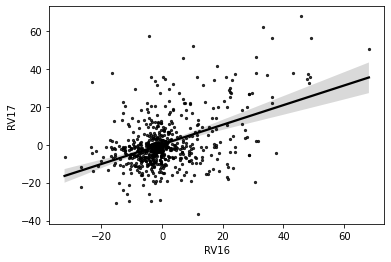

In [12]:
sns.regplot(x="RV16", y="RV17", color= 'black', fit_reg= True ,scatter_kws={'s':5},data= Players)

As before, we calculate the correlation coefficient. There clearly is a positive correlation, but it is not nearly as strong as it is for the event values.

In [13]:
np.corrcoef(Players.RV16, Players.RV17)

array([[1.        , 0.45381487],
       [0.45381487, 1.        ]])

## Self Test

One explanation for the low correlation may be that in one or both years some players have relatively few at-bats, and hence the performance measure is noisy. Identify the number of appearances by players in the 2016 and 2017 data, and then derive the correlation coefficient. What do you conclude from this?

In [16]:
#Your Code Here

## 3. Comparing Team Run Values

The next step is to compare the runs values for each team across the season, to see how closely these correlate with winning records of the teams. 

In [14]:
# Since each event is identified as occurring at the top of the inning (away team) or bottom of the inning (home team),
#we can use this variable to associate each event with the offensive record of the batter's team.

RE_17['team']= np.where(RE_17['half']=='top',RE_17['away_team'],RE_17['home_team'])
RE_17

,home_team,away_team,half,gameId,batterName,batterId,event,start1B,start2B,start3B,...,Start3,Start_State,End1,End2,End3,End_State,Start_RE,End_RE,Run_Value,team
0,tba,nya,top,gid_2017_04_02_nyamlb_tbamlb_1,Gardner,458731,Flyout,NaN,NaN,NaN,...,0,000 0,0,0,0,000 1,0.516375,0.272176,-0.244199,nya
1,tba,nya,top,gid_2017_04_02_nyamlb_tbamlb_1,"Sanchez, G",596142,Groundout,NaN,NaN,NaN,...,0,000 1,0,0,0,000 2,0.272176,0.108038,-0.164138,nya
2,tba,nya,top,gid_2017_04_02_nyamlb_tbamlb_1,Bird,595885,Walk,NaN,NaN,NaN,...,0,000 2,1,0,0,100 2,0.108038,0.225365,0.117327,nya
3,tba,nya,top,gid_2017_04_02_nyamlb_tbamlb_1,Holliday,407812,Groundout,595885.0,NaN,NaN,...,0,100 2,0,0,0,000 3,0.225365,0.000000,-0.225365,nya
4,tba,nya,bottom,gid_2017_04_02_nyamlb_tbamlb_1,"Dickerson, C",572816,Single,NaN,NaN,NaN,...,0,000 0,1,0,0,100 0,0.516375,0.912921,0.396546,tba
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184746,chn,cin,top,gid_2017_10_01_cinmlb_chnmlb_1,Vincej,572227,Runner Out,571740.0,608385.0,NaN,...,0,110 2,0,0,0,000 3,0.449782,0.000000,-0.449782,cin
184747,chn,cin,bottom,gid_2017_10_01_cinmlb_chnmlb_1,"Davis, T",543089,Groundout,NaN,NaN,NaN,...,0,000 0,0,0,0,000 1,0.516375,0.272176,-0.244199,chn
184748,chn,cin,bottom,gid_2017_10_01_cinmlb_chnmlb_1,Almora Jr.,546991,Home Run,NaN,NaN,NaN,...,0,000 1,0,0,0,000 1,0.272176,0.272176,1.000000,chn
184749,chn,cin,bottom,gid_2017_10_01_cinmlb_chnmlb_1,Freeman,502273,Groundout,NaN,NaN,NaN,...,0,000 1,0,0,0,000 2,0.272176,0.108038,-0.164138,chn


In [15]:
RE_16['team']= np.where(RE_16['half']=='top',RE_16['away_team'],RE_16['home_team'])
RE_16

,home_team,away_team,half,gameId,batterName,batterId,event,start1B,start2B,start3B,...,Start3,Start_State,End1,End2,End3,End_State,Start_RE,End_RE,Run_Value,team
0,pit,sln,top,gid_2016_04_03_slnmlb_pitmlb_1,"Carpenter, M",572761,Groundout,NaN,NaN,NaN,...,0,000 0,0,0,0,000 1,0.498377,0.268678,-0.229699,sln
1,pit,sln,top,gid_2016_04_03_slnmlb_pitmlb_1,Pham,502054,Groundout,NaN,NaN,NaN,...,0,000 1,0,0,0,000 2,0.268678,0.106305,-0.162373,sln
2,pit,sln,top,gid_2016_04_03_slnmlb_pitmlb_1,Holliday,407812,Strikeout,NaN,NaN,NaN,...,0,000 2,0,0,0,000 3,0.106305,0.000000,-0.106305,sln
3,pit,sln,bottom,gid_2016_04_03_slnmlb_pitmlb_1,Jaso,444379,Groundout,NaN,NaN,NaN,...,0,000 0,0,0,0,000 1,0.498377,0.268678,-0.229699,pit
4,pit,sln,bottom,gid_2016_04_03_slnmlb_pitmlb_1,McCutchen,457705,Hit By Pitch,NaN,NaN,NaN,...,0,000 1,1,0,0,100 1,0.268678,0.512225,0.243547,pit
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184147,sln,pit,bottom,gid_2016_10_02_pitmlb_slnmlb_1,Moss,461235,Strikeout,594824.0,NaN,NaN,...,0,100 2,0,0,0,000 3,0.220539,0.000000,-0.220539,sln
184148,sln,pit,top,gid_2016_10_02_pitmlb_slnmlb_1,"Rogers, J",595386,Groundout,NaN,NaN,NaN,...,0,000 0,0,0,0,000 1,0.498377,0.268678,-0.229699,pit
184149,sln,pit,top,gid_2016_10_02_pitmlb_slnmlb_1,Jaso,444379,Walk,NaN,NaN,NaN,...,0,000 1,1,0,0,100 1,0.268678,0.512225,0.243547,pit
184150,sln,pit,top,gid_2016_10_02_pitmlb_slnmlb_1,"Polanco, G",570256,Strikeout,444379.0,NaN,NaN,...,0,100 1,1,0,0,100 2,0.512225,0.220539,-0.291686,pit


In [16]:
# We use .groupby to calculate the sum of runs values for each team in each season and then merge to two frames to make 
# comparisons

REteam_17= RE_17.groupby(['team'])['Run_Value'].sum().reset_index().rename(columns= {"Run_Value": 'RV17'})
REteam_16= RE_16.groupby(['team'])['Run_Value'].sum().reset_index().rename(columns= {"Run_Value": 'RV16'})
REteam1617 = pd.merge(REteam_16,REteam_17, on=['team'])
REteam1617

,team,RV16,RV17
0,ana,-3.184209,-47.579782
1,ari,15.870968,62.616716
2,atl,-84.633901,-28.259905
3,bal,29.297940,-23.678031
4,bos,160.812546,9.445347
5,cha,-41.643638,-47.416033
6,chn,85.327151,71.002092
7,cin,-17.643638,5.420218
8,cle,48.815791,73.780465
9,col,122.825528,78.616716


<AxesSubplot:xlabel='RV16', ylabel='RV17'>

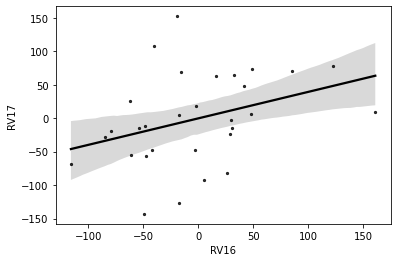

In [17]:
sns.regplot(x="RV16", y="RV17", color= 'black', fit_reg= True ,scatter_kws={'s':5},data= REteam1617)

We find a modest correlation in Runs Values between the two seasons.

In [18]:
np.corrcoef(REteam1617.RV16, REteam1617.RV17)

array([[1.        , 0.35170819],
       [0.35170819, 1.        ]])

## Self Test

Compare the correlation in Runs Values for the seasons 2015 and 2017. Do you find the same pattern? Why or why not? 

In [22]:
#Your Code Here

## 4. Comparing Run Values, Win Percentage, and Salary Data

Runs values can be considered both as a factor that explains winning - teams that achieve a higher Runs Value are performing better than expected, and hence are more likely to win - or as a predictor of winning in the future. To the extent that the market for players is efficient in an economic sense, player salaries will also reflect both current and future performance. So we can use our data to make these comparisons.

We take the salary data for 2016 from the Lahman database. We download a file which includes the regular season win percentage for each team in 2016 and 2017 and the total paid out in salaries in 2016.

In [19]:
wpcsal1617 = pd.read_excel("../Data/wpcsal2016-17.xlsx")
wpcsal1617

,team,wpc2016,wpc2017,Sal2016,lahteamname
0,ari,0.425926,0.574074,87439063,ARI
1,atl,0.422360,0.444444,68498291,ATL
2,bal,0.549383,0.462963,161863456,BAL
3,bos,0.574074,0.574074,188545761,BOS
4,cha,0.481481,0.413580,112998667,CHA
5,chn,0.635802,0.567901,154067668,CHN
6,cin,0.419753,0.419753,88940059,CIN
7,cle,0.583851,0.629630,74311900,CLE
8,col,0.462963,0.537037,112645071,COL
9,det,0.534161,0.395062,194876481,DET


## Self Test

The win percentages for each can be derived directly from RE_16 and RE_17. To do this, .groupby to sum the runs scored by each team in each game and denote the winner as the team with more runs (1 if the winner, 0 otherwise) and then use .groupby to find the mean of wins - that is win percentage. Check that your answer matches the data for win percentage downloaded here. 

In [20]:
# Here we merge the Runs Value df with the Win Percentage df

REteam1617 = pd.merge(REteam1617,wpcsal1617, on = ['team'])
REteam1617

,team,RV16,RV17,wpc2016,wpc2017,Sal2016,lahteamname
0,ana,-3.184209,-47.579782,0.456790,0.493827,137251333,LAA
1,ari,15.870968,62.616716,0.425926,0.574074,87439063,ARI
2,atl,-84.633901,-28.259905,0.422360,0.444444,68498291,ATL
3,bal,29.297940,-23.678031,0.549383,0.462963,161863456,BAL
4,bos,160.812546,9.445347,0.574074,0.574074,188545761,BOS
5,cha,-41.643638,-47.416033,0.481481,0.413580,112998667,CHA
6,chn,85.327151,71.002092,0.635802,0.567901,154067668,CHN
7,cin,-17.643638,5.420218,0.419753,0.419753,88940059,CIN
8,cle,48.815791,73.780465,0.583851,0.629630,74311900,CLE
9,col,122.825528,78.616716,0.462963,0.537037,112645071,COL


## Scatterplots

The extent of correlation among the variables can be examined using scatterplots for each pair of variables

<AxesSubplot:xlabel='RV16', ylabel='wpc2016'>

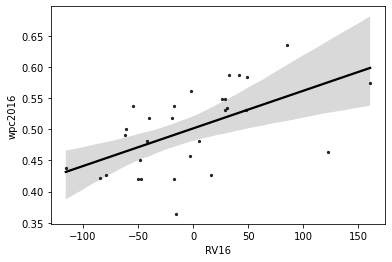

In [21]:
sns.regplot(x="RV16", y="wpc2016", color= 'black', fit_reg= True ,scatter_kws={'s':5},data= REteam1617)

<AxesSubplot:xlabel='Sal2016', ylabel='RV16'>

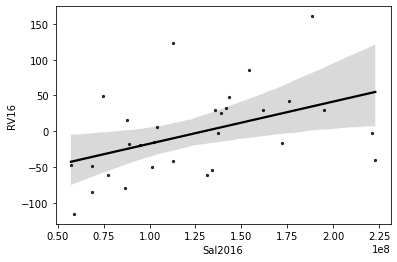

In [22]:
sns.regplot(x="Sal2016", y="RV16" , color= 'black', fit_reg= True ,scatter_kws={'s':5},data= REteam1617)

<AxesSubplot:xlabel='RV16', ylabel='wpc2017'>

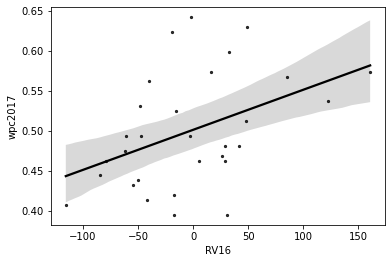

In [23]:
sns.regplot(x="RV16", y="wpc2017", color= 'black', fit_reg= True ,scatter_kws={'s':5},data= REteam1617)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Sal2016', ylabel='RV17'>

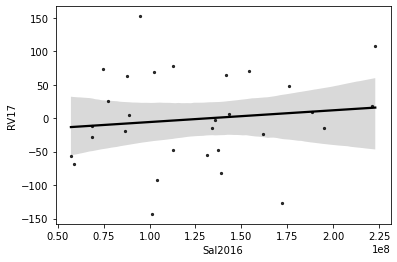

In [24]:
sns.regplot("Sal2016", y="RV17", color= 'black', fit_reg= True ,scatter_kws={'s':5},data= REteam1617)

## Correlations

We can generate a matrix of correlation coefficients using .corr()

In [27]:
REteam1617.corr()

,RV16,RV17,wpc2016,wpc2017,Sal2016
RV16,1.000000,0.351708,0.559035,0.428819,0.449702
RV17,0.351708,1.000000,0.249173,0.716763,0.118989
wpc2016,0.559035,0.249173,1.000000,0.344426,0.632696
wpc2017,0.428819,0.716763,0.344426,1.000000,0.155263
Sal2016,0.449702,0.118989,0.632696,0.155263,1.000000


## Conclusions

There is  high correlation between Runs Value and Win Percentage, especially in 2017. There is also a fairly high level of correlation between Runs Value in 2016 and Win Percentage in 2017 - it appears predictive to some extent. Runs Value is also fairly highly correlated with salary in a given year, but salaries in 2016 are not very closely correlated with Win Percentage in 2017.

There are several possible explanations for this. Salaries are not as correlated with productivity (Runs Value) as one might expect in an open market, since rookies are not able to sell their services competitively and even 5 year veterans are constrained by arbitration (recall our analysis of salaries from Hakes and Sauer). 

It is also possible that salaries are more about rewarding past performance than future performance. Your opinion on this depends on how you think the markets work. 

It may also be the case that salary data is partial and incomplete.

Runs Value is a very good measure of player productivity, which improves upon traditional statistics by taking account of context. It's no accident that statistical analysis in baseball is more advanced than in any other sport - the natural measurement of performance as the product of a series of discrete homogeneous events (at-bats) is unparalleled in sports. Baseball analysts have gone further and made adjustments to these statistics to generate a single, intuitive measure of productivity such as Wins Above Replacement (WAR). There is debate about how to make these adjustments and different versions of WAR exist. In many cases WAR is calculated on the basis of season average player stats adjusted for Run Expectancy - a method which then loses the context dependent values we have derived here. In any case, equipped with the capacity to produce Runs Value data, you should now be able to go on and produce your own version of WAR, if you so wish. An example of how to do this is given by Baumer, Jensen, and Matthews (2015) "openWAR: An open source system for evaluating overall player performance in major league baseball", which you can download online for free.

Throughout this course we have focused on the relationship between productivity, performance and valuation. We have focused mainly on using data to *explain* the relationships, but we have also seen that it can have *predictive* value. This is the underlying story behind Moneyball, but is is also the story of sports analytics in general. In the next course we will focus in more detail on prediction and forecasting.